<a href="https://colab.research.google.com/github/imraunav/anemia-detection/blob/main/anemia_efficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -o dataset.zip https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/ccr8cm22vz-1.zip
!unzip dataset.zip
!unrar x "/content/Anemia Detection using Palpable Palm Image Datasets from Ghana/Palm.rar" > op

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  231M  100  231M    0     0  30.5M      0  0:00:07  0:00:07 --:--:-- 37.8M
Archive:  dataset.zip
  inflating: Anemia Detection using Palpable Palm Image Datasets from Ghana/Palm.rar  


In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm

anemic = []
non_anemic = []
for filename in os.listdir('/content/Palm/'):
  if 'Non' in filename:
    non_anemic.append(filename)
  else:
    anemic.append(filename)

In [3]:
def read_img(filepath):
  img = cv2.imread(filepath)
  img = cv2.resize(img, (227, 227))
  # img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  # l, a, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
  # return b
  return img

In [4]:
dataset = []
labels = []
path = '/content/Palm/'
for filename in tqdm(anemic):
  labels.append(0)
  img = read_img(os.path.join(path, filename))
  dataset.append(img)
for filename in tqdm(non_anemic):
  labels.append(1)
  img = read_img(os.path.join(path, filename))
  dataset.append(img)
dataset = np.array(dataset)
labels = np.array(labels)

100%|██████████| 1698/1698 [00:10<00:00, 168.17it/s]


In [5]:
from sklearn.model_selection import train_test_split
import tensorflow as tf


train_x, test_x, train_y, test_y = train_test_split(dataset, labels, test_size=0.2, random_state=2)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.1, random_state=5)
print(train_x.shape, test_x.shape, val_x.shape)
print(train_y.shape, test_y.shape, val_y.shape)

train_x = tf.data.Dataset.from_tensor_slices(train_x)
test_x = tf.data.Dataset.from_tensor_slices(test_x)
val_x = tf.data.Dataset.from_tensor_slices(val_x)

train_y = tf.data.Dataset.from_tensor_slices(train_y)
test_y = tf.data.Dataset.from_tensor_slices(test_y)
val_y = tf.data.Dataset.from_tensor_slices(val_y)

train_ds = tf.data.Dataset.zip((train_x, train_y))
test_ds = tf.data.Dataset.zip((test_x, test_y))
val_ds = tf.data.Dataset.zip((val_x, val_y))


(3067, 227, 227, 3) (852, 227, 227, 3) (341, 227, 227, 3)
(3067,) (852,) (341,)


In [6]:
from tensorflow import keras

In [7]:
cnn = keras.applications.EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(227, 227, 3),
    include_preprocessing=True,
)
cnn.trainable = False
classifier = keras.models.Sequential(
    [
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(1024, activation='relu'),
        # keras.layers.BatchNormalization(),
        keras.layers.Dense(1024, activation='relu'),
        # keras.layers.BatchNormalization(),
        keras.layers.Dense(2, activation='softmax'),
    ],
    name='classifier'
)
model = keras.models.Sequential(
    [
        cnn,
        classifier,
    ]
)
classifier.summary()
model.summary()

24274472/24274472 [==============================] - 0s 0us/step
Model: "classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 2363394 (9.02 MB)
Trainable params: 2363394 (9.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential"

In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model_callbacks = [keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=5,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
    start_from_epoch=40,
)]
batch_size = 16
log = model.fit(train_ds.batch(batch_size), epochs=100, verbose=2, validation_data=val_ds.batch(batch_size),
                  callbacks=model_callbacks)

Epoch 1/100
192/192 - 27s - loss: 0.6253 - accuracy: 0.6547 - val_loss: 0.5701 - val_accuracy: 0.6891 - 27s/epoch - 140ms/step
Epoch 2/100
192/192 - 6s - loss: 0.4982 - accuracy: 0.7564 - val_loss: 0.4795 - val_accuracy: 0.7742 - 6s/epoch - 31ms/step
Epoch 3/100
192/192 - 6s - loss: 0.4292 - accuracy: 0.7943 - val_loss: 0.4765 - val_accuracy: 0.7625 - 6s/epoch - 32ms/step
Epoch 4/100
192/192 - 6s - loss: 0.3640 - accuracy: 0.8337 - val_loss: 0.3699 - val_accuracy: 0.8182 - 6s/epoch - 31ms/step
Epoch 5/100
192/192 - 7s - loss: 0.3182 - accuracy: 0.8595 - val_loss: 0.3176 - val_accuracy: 0.8680 - 7s/epoch - 34ms/step
Epoch 6/100
192/192 - 6s - loss: 0.2740 - accuracy: 0.8764 - val_loss: 0.3051 - val_accuracy: 0.8475 - 6s/epoch - 33ms/step
Epoch 7/100
192/192 - 6s - loss: 0.2646 - accuracy: 0.8826 - val_loss: 0.3119 - val_accuracy: 0.8651 - 6s/epoch - 32ms/step
Epoch 8/100
192/192 - 6s - loss: 0.2069 - accuracy: 0.9120 - val_loss: 0.3231 - val_accuracy: 0.8710 - 6s/epoch - 32ms/step
Epoch

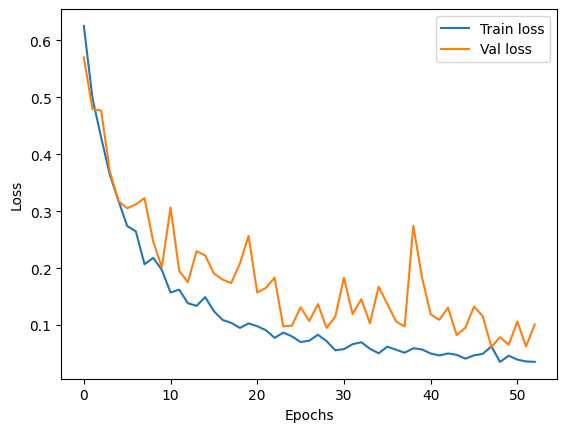

Model performance on test dataset: 
Loss: 0.03943951427936554
Accuracy: 0.9835680723190308
54/54 [==============================] - 3s 27ms/step
[[521   9]
 [  5 317]]
Model performance on train dataset: 
Loss: 0.015135703608393669
Accuracy: 0.997065544128418
192/192 [==============================] - 5s 26ms/step
[[1831    2]
 [   7 1227]]


In [ ]:
from matplotlib import pyplot as plt
plt.plot(log.history['loss'])
plt.plot(log.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train loss", "Val loss"])
plt.show()

loss, acc = model.evaluate(test_ds.batch(batch_size), verbose=0)
print("Model performance on test dataset: ")
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")

y_pred = model.predict(test_x.batch(batch_size))
y_pred = tf.math.argmax(
    y_pred,
    axis=1)
y_test_list = list(test_y.as_numpy_iterator())
cm = tf.math.confusion_matrix(y_test_list, y_pred).numpy()
print(cm)

loss, acc = model.evaluate(train_ds.batch(batch_size), verbose=0)
print("Model performance on train dataset: ")
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")

y_pred = model.predict(train_x.batch(batch_size))
y_pred = tf.math.argmax(
    y_pred,
    axis=1)
y_train_list = list(train_y.as_numpy_iterator())
cm = tf.math.confusion_matrix(y_train_list, y_pred).numpy()
print(cm)

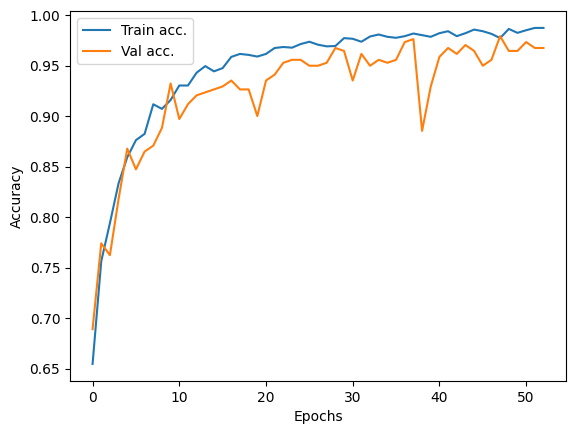

In [ ]:
plt.plot(log.history['accuracy'])
plt.plot(log.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train acc.", "Val acc."])
plt.show()

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
filepath = './drive/MyDrive/anemia-classifier-efficientNetB0.h5'
# classifier.save_weights(filepath, overwrite=True, save_format=None, options=None)

In [10]:
classifier.load_weights(filepath)
model = keras.models.Sequential(
    [
        cnn,
        classifier,
    ]
)
batch_size=16
y_pred = model.predict(test_x.batch(batch_size))
y_pred = tf.math.argmax(
    y_pred,
    axis=1)
y_test_list = list(test_y.as_numpy_iterator())
cm = tf.math.confusion_matrix(y_test_list, y_pred).numpy()
print(cm)

54/54 [==============================] - 59s 1s/step
[[525   5]
 [  2 320]]


In [11]:
accuracy = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[1,1]+cm[0,1]+cm[1,0])
print("Accuracy: ", accuracy)

precision = (cm[0,0])/(cm[0,0]+cm[0,1])
print("Precision: ", precision)

recall = (cm[0,0])/(cm[0,0]+cm[1,0])
print("Precision: ", recall)

f1score = 2*(1/precision + 1/recall)
print("F1-score: ", f1score)

Accuracy:  0.9917840375586855
Precision:  0.9905660377358491
Precision:  0.9962049335863378
F1-score:  4.026666666666666
